In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

In [2]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        "DO NOT EVER include FINAL ANSWER in your output unless you are the verification agent."
        f"\n{suffix}"
    )

In [3]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

llm = ChatOpenAI(model="gpt-4o")

def get_next_node(last_message: BaseMessage, primary: str, default: str | None = None):
    """
    Decide the next node in the workflow.
    
    - If 'FINAL ANSWER' appears in the last message, go to END.
    - Otherwise, try the primary branch first.
    - If the primary is None or invalid, fall back to default.
    """
    if "FINAL ANSWER" in last_message.content:
        return END
    if "VERIFICATION" in last_message.content:
        return default
    return primary


# ---------- Translator Agent ----------
translator = create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        """You are the translator agent.
        Your role is to parse natural language Olympiad math problems into a structured form.
        The resulting text should be a purely mathematical problem, without any fluff.
        Do NOT attempt to solve the problem.
        If the inputted problem is already purely mathematical, send it to the reasoner.
        """
    ),
)

def translator_node(state: MessagesState) -> Command[Literal["reasoner", END]]:
    result = translator.invoke(state)
    goto = get_next_node(result["messages"][-1], "reasoner")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="translator"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


# ---------- Computation Agent ----------
computation = create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        """You are the computation agent.
        Your role is to handle symbolic algebra, numeric calculations, equation solving, and manipulations.
        Do NOT decide which formulas to apply; just execute computations.
        You are working with a reasoner agent who will tell you what to do.
        Your answers should be as short as possible, just containing the answer.
        """
    ),
)

def computation_node(state: MessagesState) -> Command[Literal["reasoner", END]]:
    result = computation.invoke(state)
    goto = get_next_node(result["messages"][-1], "reasoner")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="computation"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


# ---------- Reasoning Agent ----------
reasoner = create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        """You are the reasoning agent.
        Your role is to plan the solution path, apply mathematical theorems, 
        and orchestrate which computations are needed.
        Always request computations from the Computation Agent 
        instead of doing calculations yourself.
        After computations return, continue building the solution step-by-step.
        Once you have a final answer, ALWAYS pass it to the verifier agent.
        Put VERIFICATION in your output once you want the verification agent to verify your answer.
        """
    ),
)

def reasoner_node(state: MessagesState) -> Command[Literal["verification", "computation", END]]:
    result = reasoner.invoke(state)
    goto = get_next_node(result["messages"][-1], "computation", default="verification")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="reasoner"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


# ---------- Verification Agent ----------
verification = create_react_agent(
    llm,
    tools=[],  # optional consistency checker
    prompt=make_system_prompt(
        """You are the verification agent.
        Your job is to carefully check the logical correctness of the reasoning 
        and the computations. Ensure that assumptions are valid, 
        the final answer satisfies the original problem, and no step is skipped.
        If errors are found, send feedback back to the reasoning agent.
        Otherwise, finalize the solution by putting FINAL ANSWER right before the answer.
        DO NOT put FINAL ANSWER in your output unless it is the correct solution.
        """
    ),
)

def verification_node(state: MessagesState) -> Command[Literal["reasoner", END]]:
    result = verification.invoke(state)
    goto = get_next_node(result["messages"][-1], "reasoner", default=END)
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="verification"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


# ---------- Wiring the Graph ----------
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("translator", translator_node)
workflow.add_node("computation", computation_node)
workflow.add_node("reasoner", reasoner_node)
workflow.add_node("verification", verification_node)

# Define entry point
workflow.add_edge(START, "translator")

# Build graph
graph = workflow.compile()


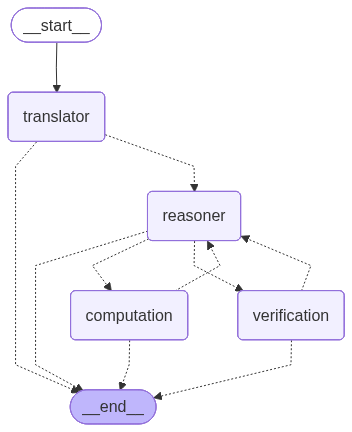

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
from datasets import load_dataset

# Load OlympiadBench (this may take a bit the first time)
dataset = load_dataset("Hothan/OlympiadBench", 'OE_TO_maths_en_COMP')

/opt/anaconda3/envs/vscode/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import random
random.seed(83)
split = random.sample(list(dataset['train']), 50)

In [ ]:
import json
from langchain_core.messages import BaseMessage

def to_serializable(obj):
    """Recursively convert LangChain BaseMessage objects into dicts."""
    if isinstance(obj, BaseMessage):
        return obj.dict()
    elif isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_serializable(i) for i in obj]
    else:
        return obj
    
for i in range(13):
# for i in range(1):

    q = split[i]
    # q = {'final_answer': "3986729", 'question': "On a square table of 2011 by 2011 cells we place a finite number of napkins that each cover a square of 52 by 52 cells. In each cell we write the number of napkins covering it, and we record the maximal number $k$ of cells that all contain the same nonzero number. Considering all possible napkin configurations, what is the largest value of $k$ ?"}
    print(q['question'])

    events = graph.stream(
        {
            "messages": [
                (
                    "user",
                    q['question']
                )
            ],
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": 75},
    )

    last_event = None
    try:
        for s in events:
            print(list(s.keys())[0])
            last_event = s
    except Exception:
        pass
    
    print("TERMINATED----")
    last_event = to_serializable(last_event)
    # print(last_event)
    last_msg = last_event[list(last_event.keys())[0]]['messages'][-1]['content']
    index = last_msg.find("FINAL ANSWER")

    if index != -1:
        result = last_msg[index + len("FINAL ANSWER"):].strip()
        print(result)
    
    print("ACTUAL FINAL ANSWER: " + '\n'.join(q['final_answer']))
    print("---------")

    with open("trace_math/trace_" + str(i+1) + ".txt", "w") as f:
        f.write(json.dumps(last_event[list(last_event.keys())[0]]['messages'], indent=4))
    
    with open("trace_math/trace_add_" + str(i+1) + ".txt", "w") as f:
        f.write("MAS FINAL ANSWER: " + str(result) + '\n')
        f.write("TRUE FINAL ANSWER: " + '\n'.join(q['final_answer']) + '\n')
        f.write("\n---------\n")
        f.write("TRUE SOLUTION: " + '\n'.join(q['solution']))


Let $T=4$ and let $k=21+2 T$. Compute the largest integer $n$ such that $2 n^{2}-k n+77$ is a positive prime number.
translator
reasoner
computation
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Let $T=4$ and let $k=21+2 T$. Compute the largest integer $n$ such that $2 n^{2}-k n+77$ is a positive prime number.Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '9ce8af8e-da5f-4929-9524-48643be071a3', 'example': False}, {'content': 'Let \\( T = 4 \\) and \\( k = 21 + 2T \\).\n\nCompute the largest integer \\( n \\) such that \\( 2n^2 - kn + 77 \\) is a positive prime number.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': 'translator', 'id': '46eb9750-c9f7-45c3-af52-33ba30aa5089', 'example': False}, {'content': "First, let's substitute the value of \\( T = 4 \\) to find \\( k \\):\n\n\\[\nk = 21 + 2T = 21 + 2 \\times 4 = 21 + 8 = 29\n

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Triangle $A B C$ has $\\mathrm{m} \\angle A>\\mathrm{m} \\angle B>\\mathrm{m} \\angle C$. The angle between the altitude and the angle bisector at vertex $A$ is $6^{\\circ}$. The angle between the altitude and the angle bisector at vertex $B$ is $18^{\\circ}$. Compute the degree measure of angle $C$.Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '087bbce7-0cdc-46ec-bb80-b0117ba18b8d', 'example': False}, {'content': 'Triangle \\( ABC \\) has angles such that \\( \\angle A > \\angle B > \\angle C \\). Let:\n- \\( D \\) be the foot of the altitude from \\( A \\) to \\( BC \\).\n- \\( E \\) be the point on \\( BC \\) such that \\( AE \\) is the angle bisector of \\( \\angle A \\).\n- \\( F \\) be the foot of the altitude from \\( B \\) to \\( AC \\).\n- \\( G \\) be the point on \\( AC \\) such that \\( 

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Let $\\mathbb{Q}_{>0}$ denote the set of all positive rational numbers. Determine all functions $f: \\mathbb{Q}_{>0} \\rightarrow \\mathbb{Q}_{>0}$ satisfying\n\n$$\nf\\left(x^{2} f(y)^{2}\\right)=f(x)^{2} f(y)\n\\tag{*}\n$$\n\nfor all $x, y \\in \\mathbb{Q}_{>0}$.Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'fac63564-9665-4d99-ace8-9ba0b5c35c8f', 'example': False}, {'content': 'Determine all functions \\( f: \\mathbb{Q}_{>0} \\rightarrow \\mathbb{Q}_{>0} \\) satisfying\n\n\\[\nf\\left(x^{2} f(y)^{2}\\right)=f(x)^{2} f(y)\n\\]\n\nfor all \\( x, y \\in \\mathbb{Q}_{>0} \\).', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': 'translator', 'id': '9d17de41-7c62-4ed2-b0ce-5fb809d6a93d', 'example': False}, {'content': "To solve this functional equation, we'll analyze the structu

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Determine, with justification, all values of $k$ for which $y=x^{2}-4$ and $y=2|x|+k$ do not intersect.Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'd9b3315e-df24-4b12-80f6-d53c5e06aaaa', 'example': False}, {'content': 'Find all values of \\( k \\) such that the equations \\( y = x^2 - 4 \\) and \\( y = 2|x| + k \\) have no solutions for \\( x \\).\n\n1. Consider the graphs of the equations:\n   - \\( y = x^2 - 4 \\) is a parabola with vertex at \\( (0, -4) \\).\n   - \\( y = 2|x| + k \\) is a V-shaped graph with vertex at \\( (0, k) \\).\n\n2. The equations do not intersect if there are no solutions to:\n   \\[\n   x^2 - 4 = 2|x| + k\n   \\]\n\n3. Analyze separately for \\( x \\geq 0 \\) and \\( x < 0 \\):\n   - For \\( x \\geq 0 \\):\n     \\[\n     x^2 - 4 = 2x + k \\quad \\Rightarrow \\quad x^2

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'A regular hexagon has side length 1. Compute the average of the areas of the 20 triangles whose vertices are vertices of the hexagon.Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '609bddaf-4e90-4447-8914-a4e2c7090008', 'example': False}, {'content': 'Given a regular hexagon with side length 1. Let its vertices be \\( A_1, A_2, A_3, A_4, A_5, A_6 \\). \n\n1. Consider all possible triangles formed by choosing three different vertices from this hexagon. \n2. There are \\( \\binom{6}{3} = 20 \\) such triangles.\n3. Compute the average area of these 20 triangles. \n\nDo not solve the problem.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': 'translator', 'id': 'b5518863-f7f6-4d2d-99ad-79696a1a32bb', 'example': False}, {'content': "Let'

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Determine the largest $N$ for which there exists a table $T$ of integers with $N$ rows and 100 columns that has the following properties:\n\n(i) Every row contains the numbers 1,2, ., 100 in some order.\n\n(ii) For any two distinct rows $r$ and $s$, there is a column $c$ such that $|T(r, c)-T(s, c)| \\geqslant 2$.\n\nHere $T(r, c)$ means the number at the intersection of the row $r$ and the column $c$.Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'bfc2eb9e-9e7b-48a8-a7e7-c7be3c6b88c7', 'example': False}, {'content': 'Determine the largest integer $N$ for which there exists an $N \\times 100$ table $T$ of integers such that:\n\n1. Each row contains the numbers $1, 2, \\ldots, 100$ in some permutation.\n\n2. For any two distinct rows $r$ and $s$, there exists a column $c$ such tha

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Let $n$ be a positive integer. Determine the smallest positive integer $k$ with the following property: it is possible to mark $k$ cells on a $2 n \\times 2 n$ board so that there exists a unique partition of the board into $1 \\times 2$ and $2 \\times 1$ dominoes, none of which contains two marked cells.Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3a96f5d9-0e65-4609-a270-2efb64215fe7', 'example': False}, {'content': 'Determine the smallest positive integer \\( k \\) such that there exists a unique partition of a \\( 2n \\times 2n \\) board into \\( 1 \\times 2 \\) and \\( 2 \\times 1 \\) dominoes, where no domino contains two marked cells.\n', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': 'translator', 'id': '8455ab57-12b0-4e93-9e7e-fca8ac7a473b',

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Let $T=72 \\sqrt{2}$, and let $K=\\left(\\frac{T}{12}\\right)^{2}$. In the sequence $0.5,1,-1.5,2,2.5,-3, \\ldots$, every third term is negative, and the absolute values of the terms form an arithmetic sequence. Compute the sum of the first $K$ terms of this sequence.Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'af849f9c-dd77-4c5a-8f73-f4ea9813a047', 'example': False}, {'content': 'Given: \n\n- \\( T = 72 \\sqrt{2} \\)\n- \\( K = \\left( \\frac{T}{12} \\right)^2 \\)\n\nSequence: \\( 0.5, 1, -1.5, 2, 2.5, -3, \\ldots \\)\n\nThis sequence has the property that every third term is negative, and the absolute values of the terms form an arithmetic sequence.\n\nTask: Compute the sum of the first \\( K \\) terms of this sequence.', 'additional_kwargs': {}, 'respon

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
computation
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'A bag contains 3 red marbles and 6 blue marbles. Akshan removes one marble at a time until the bag is empty. Each marble that they remove is chosen randomly from the remaining marbles. Given that the first marble that Akshan removes is red and the third marble that they remove is blue, what is the probability that the last two marbles that Akshan removes are both blue?Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'd8785c7d-a779-4804-941a-66929f2cbd7c', 'example': False}, {'content': 'A bag contains 3 red marbles and 6 blue marbles. The sequence of marble removals is such that the first marble removed is red, and the third is blue. Determine the probability that the last two marbles removed are both blue.', 'additional_kwargs': {}, 'response_metadata': {}, 't

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Without using a calculator, determine positive integers $m$ and $n$ for which\n\n$$\n\\sin ^{6} 1^{\\circ}+\\sin ^{6} 2^{\\circ}+\\sin ^{6} 3^{\\circ}+\\cdots+\\sin ^{6} 87^{\\circ}+\\sin ^{6} 88^{\\circ}+\\sin ^{6} 89^{\\circ}=\\frac{m}{n}\n$$\n\n(The sum on the left side of the equation consists of 89 terms of the form $\\sin ^{6} x^{\\circ}$, where $x$ takes each positive integer value from 1 to 89.)Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'bfaccbd5-3ac4-4909-974a-5b3c10c06ab4', 'example': False}, {'content': 'Determine positive integers \\( m \\) and \\( n \\) such that\n\n\\[\n\\sin ^{6} 1^{\\circ}+\\sin ^{6} 2^{\\circ}+\\sin ^{6} 3^{\\circ}+\\cdots+\\sin ^{6} 87^{\\circ}+\\sin ^{6} 88^{\\circ}+\\sin ^{6} 89^{\\circ} = \\frac{m}{n}\n\\]', 'additional_kwargs': {}, 'response_metadata': {}, '

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Determine all triples $(x, y, z)$ of real numbers that satisfy the following system of equations:\n\n$$\n\\begin{aligned}\n(x-1)(y-2) & =0 \\\\\n(x-3)(z+2) & =0 \\\\\nx+y z & =9\n\\end{aligned}\n$$Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '0a9e0f2f-d840-4925-99cf-29cb661e3d5c', 'example': False}, {'content': 'Determine all triples \\((x, y, z)\\) of real numbers such that:\n\n1. \\((x-1)(y-2) = 0\\)\n2. \\((x-3)(z+2) = 0\\)\n3. \\(x + yz = 9\\)', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': 'translator', 'id': '27a1aed0-85f8-4ce0-9cb0-5b7d039478a7', 'example': False}, {'content': "To solve the given system of equations, let's consider each equation individually and then analyze their implications collectively.\n\n1. From the equation \\((x-1)(y-2) = 0\\), we have tw

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
computation
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Determine the coordinates of the points of intersection of the graphs of $y=\\log _{10}(x-2)$ and $y=1-\\log _{10}(x+1)$.Once you have successfully completed the task, finish.', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '7f4987e4-f2db-4ae9-bbcc-ebd3df9012f9', 'example': False}, {'content': 'Find the coordinates of the intersection points of the functions:\n\n\\[ y = \\log_{10}(x - 2) \\]\n\nand\n\n\\[ y = 1 - \\log_{10}(x + 1) \\]', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': 'translator', 'id': '076b12cc-1411-44a3-96b0-2a97760a34e9', 'example': False}, {'content': "To find the intersection points of the graphs \\( y = \\log_{10}(x-2) \\) and \\( y = 1 - \\log_{10}(x+1) \\), we need to set the equations equal to each other and solve for \\( x \\):\n\n\\[\n\\log_{10}(x - 2) = 1 - \\log_{10}(x + 1)\n\\

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner
verification
TERMINATED----
{'verification': {'messages': [{'content': 'Lucy starts by writing $s$ integer-valued 2022-tuples on a blackboard. After doing that, she can take any two (not necessarily distinct) tuples $\\mathbf{v}=\\left(v_{1}, \\ldots, v_{2022}\\right)$ and $\\mathbf{w}=\\left(w_{1}, \\ldots, w_{2022}\\right)$ that she has already written, and apply one of the following operations to obtain a new tuple:\n\n$$\n\\begin{aligned}\n& \\mathbf{v}+\\mathbf{w}=\\left(v_{1}+w_{1}, \\ldots, v_{2022}+w_{2022}\\right) \\\\\n& \\mathbf{v} \\vee \\mathbf{w}=\\left(\\max \\left(v_{1}, w_{1}\\right), \\ldots, \\max \\left(v_{2022}, w_{2022}\\right)\\right)\n\\end{aligned}\n$$\n\nand then write this tuple on the blackboard.\n\nIt turns out that, in this way, Lucy can write any integer-valued 2022-tuple on the blackboard after finitely many steps. What is the smallest possible number $s$ of tuples that she initially wrote?Once you have successfully completed the task

/var/folders/7s/rmnhr2bs3bjcf3pk5tng9qqw0000gn/T/ipykernel_95709/2302272696.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return obj.dict()


translator
reasoner


KeyboardInterrupt: 